<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/Colab_Script_LightGBM_otsonipiikkien_ennustamiseen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- LightGBM Ozone Spike Prediction Script ---

Ladataan ozone dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv
Datan (ozone) käsittely valmis, muoto: (43180, 1)

Ladataan weather dataa: https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv
Datan (weather) käsittely valmis, muoto: (43463, 3)

Yhdistetään otsoni- ja säädata...
Uudelleenotanta ('resample') tunneittaiseen taajuuteen...
Löytyi 4180 NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...
Datan yhdistäminen ja resample onnistui.

--- 3. Piikkien määrittely ---


<ipython-input-1-c83e370ad9f3>:113: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True); df_merged.fillna(method='bfill', inplace=True)


Piikin kynnysarvo (90. persentiili): 77.10 µg/m³

--- 4. Piirteiden muokkaus ---
Luodaan aikaan perustuvia piirteitä...
Luodaan viivepiirteet [1, 2, 3, 6, 12, 24, 48, 72] tunnin jaksoilla...
Luodaan liukuvia tilastoja [3, 6, 12, 24, 48] tunnin ikkunoilla...
Poistettu 72 riviä piirteiden muokkauksen jälkeen.

--- 5. Datan jako opetus- ja testijoukkoihin ---
Puhdistetaan sarakkeiden nimet...
Sarakkeiden nimet puhdistettu.
Opetusdata: 2020-04-04 00:00:00 - 2024-07-02 08:00:00 (37209 riviä)
Testidata: 2024-07-02 09:00:00 - 2025-04-01 23:00:00 (6567 riviä)

--- 6. Skaalataan piirteet ---
Skaalaus valmis.

--- 7. LightGBM-mallin koulutus ja evaluointi ---
Koulutetaan LightGBM-mallia...
[LightGBM] [Info] Number of positive: 3881, number of negative: 33328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11407
[LightGBM] [Info] Number of data points in t

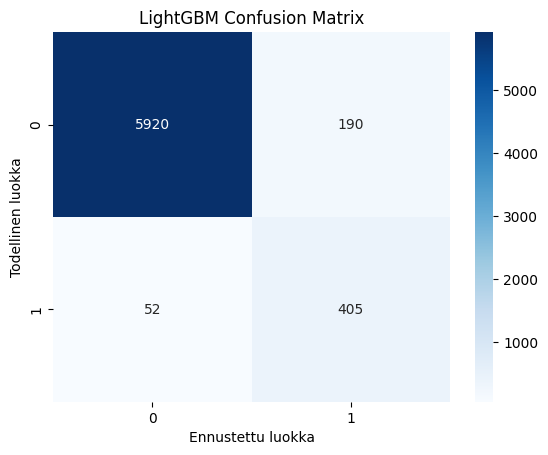

LightGBM:n metriikat tallennettu.
LightGBM ROC AUC Score: 0.9881
LightGBM PR AUC: 0.8975


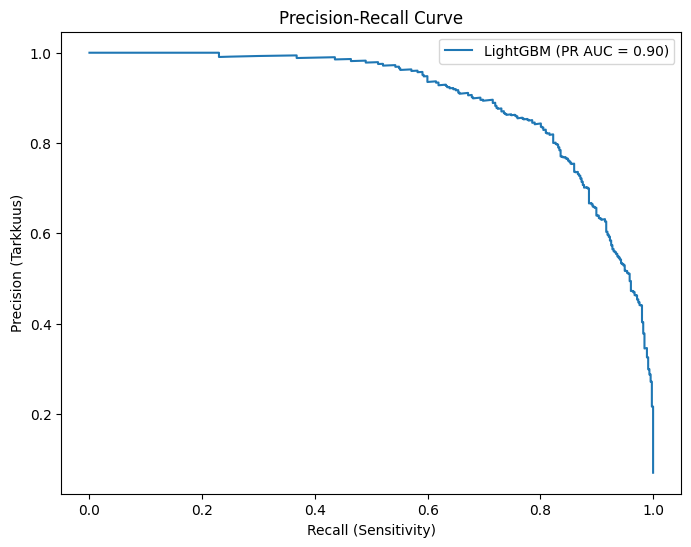


LightGBM Piirteiden tärkeys (Top 20):
                               Feature  Importance
9                  Otsoni__µg_m___lag1         306
10                 Otsoni__µg_m___lag2         123
1                Keskituulen_nopeus_ms         120
41         Otsoni__µg_m___roll_mean_3h         114
42          Otsoni__µg_m___roll_std_3h         112
0               Lämpötilan_keskiarvo_C         104
44          Otsoni__µg_m___roll_std_6h          92
28       Keskituulen_nopeus__m_s__lag6          79
14                Otsoni__µg_m___lag24          78
26       Keskituulen_nopeus__m_s__lag2          75
39  Ilmanpaineen_keskiarvo__hPa__lag48          67
29      Keskituulen_nopeus__m_s__lag12          66
16                Otsoni__µg_m___lag72          65
21     Lämpötilan_keskiarvo___C__lag12          63
38  Ilmanpaineen_keskiarvo__hPa__lag24          63
3                             hour_sin          62
4                             hour_cos          61
31      Keskituulen_nopeus__m_s__lag48     

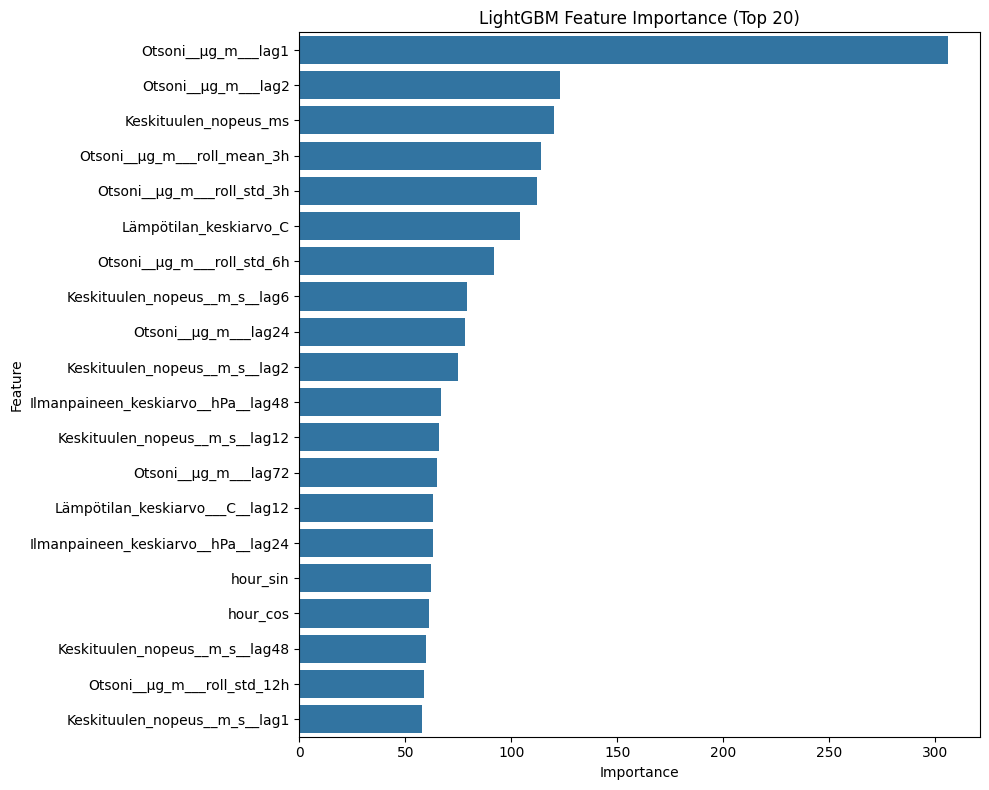


--- 8. Mallien vertailu ---
          Accuracy  Precision (Spike)  Recall (Spike)  F1-score (Spike)  \
LightGBM    0.9631             0.6807          0.8862              0.77   

          ROC AUC  PR AUC  
LightGBM   0.9881  0.8975  

--- LightGBM-skripti päättyi ---


In [1]:
# -*- coding: utf-8 -*-
"""
Colab Script for Ozone Spike Prediction using LightGBM

Loads Kallio ozone and Kaisaniemi weather data, merges, resamples,
engineers time-series features, defines spikes, trains a LightGBM
classifier, evaluates performance, and adds results to the comparison framework.
"""

# Kirjastojen tuonti
import pandas as pd
import numpy as np
import io
import requests
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import traceback
import lightgbm as lgb # LightGBM-kirjasto
import re

# Koneoppimiskirjastot
from sklearn.model_selection import train_test_split, TimeSeriesSplit # Huom: CV/Tuning ei tässä versiossa aktiivinen
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             confusion_matrix, classification_report)

print("--- LightGBM Ozone Spike Prediction Script ---")

# --- Globaali sanakirja mallien vertailuun ---
# Ladataan mahdolliset aiemmat tulokset (jos tämä ajetaan erikseen)
# Tai alustetaan tyhjäksi, jos ajetaan osana isompaa kokonaisuutta
# Tässä oletetaan, että se voi olla olemassa aiemmista ajoista
try:
    # Jos model_comparison_metrics on jo määritelty, käytä sitä
    if 'model_comparison_metrics' not in globals():
        model_comparison_metrics = {}
except NameError:
     model_comparison_metrics = {}


# --- Funktiot datan lataamiseen ja peruspuhdistukseen ---
# (Sama kuin aiemmin)
def load_and_clean_data(raw_url, data_type='weather', cols_to_keep=None):
    """Lataa ja esikäsittelee datan, pitäen vain tarvittavat sarakkeet."""
    print(f"\nLadataan {data_type} dataa: {raw_url}")
    df_local = None
    try:
        response = requests.get(raw_url)
        response.raise_for_status()
        encoding = 'utf-8' if data_type == 'weather' else 'iso-8859-1'
        csv_content = io.StringIO(response.content.decode(encoding))
        if data_type == 'ozone':
             column_names_ozone = ["Havaintoasema", "Vuosi", "Kuukausi", "Päivä", "Aika [Paikallinen aika]", "Otsoni [µg/m³]"]
             df_local = pd.read_csv(
                  csv_content, sep=',', decimal=',', skiprows=1, header=None,
                  names=column_names_ozone, quoting=csv.QUOTE_NONNUMERIC, low_memory=False)
             target_col = "Otsoni [µg/m³]"
             if target_col in df_local.columns: df_local[target_col] = pd.to_numeric(df_local[target_col], errors='coerce')
             else: raise ValueError(f"Otsonisarake '{target_col}' ei löytynyt.")
        elif data_type == 'weather':
            df_local = pd.read_csv(csv_content, sep=',', decimal='.', low_memory=False)
            df_local.columns = df_local.columns.str.strip()
            weather_cols_to_convert = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Tuulen suunnan keskiarvo [°]', 'Ilmanpaineen keskiarvo [hPa]']
            for col in weather_cols_to_convert:
                 if col in df_local.columns: df_local[col] = pd.to_numeric(df_local[col], errors='coerce')
        else: raise ValueError(f"Tuntematon data_type: {data_type}")
        year_col, month_col, day_col, time_col = 'Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]'
        required_dt_cols = [year_col, month_col, day_col, time_col]
        if not all(col in df_local.columns for col in required_dt_cols): raise ValueError(f"Aikaleiman luontiin vaadittavia sarakkeita puuttuu: {required_dt_cols}")
        df_local[year_col] = pd.to_numeric(df_local[year_col], errors='coerce').astype('Int64'); df_local[month_col] = pd.to_numeric(df_local[month_col], errors='coerce').astype('Int64'); df_local[day_col] = pd.to_numeric(df_local[day_col], errors='coerce').astype('Int64')
        if df_local[required_dt_cols].isnull().any().any(): df_local.dropna(subset=required_dt_cols, inplace=True)
        df_local[year_col] = df_local[year_col].astype(str); df_local[month_col] = df_local[month_col].astype(str).str.zfill(2); df_local[day_col] = df_local[day_col].astype(str).str.zfill(2); df_local[time_col] = df_local[time_col].astype(str)
        time_str = df_local[time_col].str.replace('24:00', '00:00', regex=False)
        datetime_str = df_local[year_col] + '-' + df_local[month_col] + '-' + df_local[day_col] + ' ' + time_str
        df_local['Timestamp'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M', errors='coerce')
        df_local.loc[df_local[time_col] == '24:00', 'Timestamp'] += pd.Timedelta(days=1)
        cols_to_select = ['Timestamp'] + (cols_to_keep if cols_to_keep else []); missing_cols = [col for col in cols_to_select if col not in df_local.columns]
        if missing_cols: raise ValueError(f"Vaadittuja sarakkeita puuttuu datasta: {missing_cols}")
        df_local = df_local[cols_to_select].copy()
        df_local.dropna(subset=['Timestamp'] + (cols_to_keep if cols_to_keep else []), inplace=True)
        df_local.set_index('Timestamp', inplace=True); df_local.sort_index(inplace=True)
        duplicates = df_local.index.duplicated(keep='first')
        if duplicates.sum() > 0: df_local = df_local[~duplicates]
        print(f"Datan ({data_type}) käsittely valmis, muoto: {df_local.shape}")
        if df_local.empty: print(f"VAROITUS: {data_type} DataFrame on tyhjä!")
        return df_local
    except requests.exceptions.RequestException as e: print(f"Virhe datan haussa URL:sta ({data_type}): {e}"); return None
    except Exception as e: print(f"Virhe datan käsittelyssä ({data_type}): {e}"); traceback.print_exc(); return None

# --- 1. Datan lataus ---
ozone_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kallio%202_%201.4.2020%20-%201.4.2025_f5d0d5ac-9f7d-4833-a70b-c1afe4dc935a.csv"
weather_url = "https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/raw/Helsinki%20Kaisaniemi_%201.4.2020%20-%201.4.2025_d5590617-bf91-46c7-96f4-1fb70892265d.csv"
o3_col = "Otsoni [µg/m³]"
weather_cols = ['Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]']
df_ozone = load_and_clean_data(ozone_url, data_type='ozone', cols_to_keep=[o3_col])
df_weather = load_and_clean_data(weather_url, data_type='weather', cols_to_keep=weather_cols)

# --- 2. Datan yhdistäminen & RESAMPLE ---
df_merged = None
if df_ozone is not None and not df_ozone.empty and df_weather is not None and not df_weather.empty:
    print("\nYhdistetään otsoni- ja säädata...")
    df_merged_raw = pd.merge(df_ozone, df_weather, left_index=True, right_index=True, how='inner')
    df_merged_raw.dropna(inplace=True)
    if not df_merged_raw.empty:
        print("Uudelleenotanta ('resample') tunneittaiseen taajuuteen...")
        df_merged = df_merged_raw.resample('h').mean()
        nan_after_resample = df_merged.isnull().sum().sum()
        if nan_after_resample > 0:
            print(f"Löytyi {nan_after_resample} NaN-arvoa resamplen jälkeen. Interpoloidaan (time)...")
            df_merged.interpolate(method='time', inplace=True)
            df_merged.fillna(method='ffill', inplace=True); df_merged.fillna(method='bfill', inplace=True)
        if df_merged.isnull().any().any(): df_merged.dropna(inplace=True)
        if df_merged.empty: print("Virhe: Data tyhjä resamplen jälkeen."); df_merged = None
        else: print("Datan yhdistäminen ja resample onnistui.")
    else: print("Virhe: Yhdistetty data tyhjä ennen resamplea."); df_merged = None

# Jatka vain jos data ok
if df_merged is not None:

    # --- 3. Piikkien määrittely ---
    print("\n--- 3. Piikkien määrittely ---")
    spike_threshold = df_merged[o3_col].quantile(0.90)
    df_merged['onko_piikki'] = (df_merged[o3_col] > spike_threshold).astype(int)
    print(f"Piikin kynnysarvo ({0.90*100:.0f}. persentiili): {spike_threshold:.2f} µg/m³")

    # --- 4. Piirteiden muokkaus ---
    print("\n--- 4. Piirteiden muokkaus ---")
    print("Luodaan aikaan perustuvia piirteitä...")
    df_merged['hour_sin'] = np.sin(2 * np.pi * df_merged.index.hour / 24); df_merged['hour_cos'] = np.cos(2 * np.pi * df_merged.index.hour / 24)
    df_merged['dayofweek_sin'] = np.sin(2 * np.pi * df_merged.index.dayofweek / 7); df_merged['dayofweek_cos'] = np.cos(2 * np.pi * df_merged.index.dayofweek / 7)
    df_merged['month_sin'] = np.sin(2 * np.pi * df_merged.index.month / 12); df_merged['month_cos'] = np.cos(2 * np.pi * df_merged.index.month / 12)
    features_to_lag = [o3_col] + weather_cols; lag_periods = [1, 2, 3, 6, 12, 24, 48, 72]
    print(f"Luodaan viivepiirteet {lag_periods} tunnin jaksoilla...")
    for col in features_to_lag:
        for lag in lag_periods:
            sanitized_col_name = re.sub(r'[\[\]<>°/³\s]', '_', col)
            df_merged[f'{sanitized_col_name}_lag{lag}'] = df_merged[col].shift(lag)
    rolling_window_hours = [3, 6, 12, 24, 48]
    print(f"Luodaan liukuvia tilastoja {rolling_window_hours} tunnin ikkunoilla...")
    for window in rolling_window_hours:
        shifted_o3 = df_merged[o3_col].shift(1)
        sanitized_o3_col_name = re.sub(r'[\[\]<>°/³\s]', '_', o3_col)
        df_merged[f'{sanitized_o3_col_name}_roll_mean_{window}h'] = shifted_o3.rolling(window=window).mean()
        df_merged[f'{sanitized_o3_col_name}_roll_std_{window}h'] = shifted_o3.rolling(window=window).std()
    initial_rows = len(df_merged); df_merged.dropna(inplace=True)
    print(f"Poistettu {initial_rows - len(df_merged)} riviä piirteiden muokkauksen jälkeen.")
    if df_merged.empty: print("Virhe: Data tyhjä piirteiden muokkauksen jälkeen."); df_merged = None

if df_merged is not None:
    # --- 5. Datan jako opetus- ja testijoukkoihin ---
    print("\n--- 5. Datan jako opetus- ja testijoukkoihin ---")
    target = 'onko_piikki'
    features_orig_names = [col for col in df_merged.columns if col not in [o3_col, target]]
    X = df_merged[features_orig_names]
    y = df_merged[target]
    print("Puhdistetaan sarakkeiden nimet...")
    def sanitize_col_names(df_or_list):
        if isinstance(df_or_list, pd.DataFrame): cols = df_or_list.columns
        elif isinstance(df_or_list, list): cols = df_or_list
        else: return df_or_list
        new_cols = []
        for col in cols:
            new_col = str(col); new_col = re.sub(r'[\[\]<>°/³]', '', new_col); new_col = re.sub(r'\s+', '_', new_col)
            new_cols.append(new_col)
        if isinstance(df_or_list, pd.DataFrame): df_or_list.columns = new_cols; return df_or_list
        elif isinstance(df_or_list, list): return new_cols
    X = sanitize_col_names(X.copy())
    features = X.columns.tolist()
    print("Sarakkeiden nimet puhdistettu.")
    test_size = 0.15
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    print(f"Opetusdata: {X_train.index.min()} - {X_train.index.max()} ({len(X_train)} riviä)")
    print(f"Testidata: {X_test.index.min()} - {X_test.index.max()} ({len(X_test)} riviä)")

    # --- 6. Piirteiden skaalaus ---
    print("\n--- 6. Skaalataan piirteet ---")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
    X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=features)
    print("Skaalaus valmis.")

    # --- 7. LightGBM-mallin koulutus ja evaluointi ---
    print("\n--- 7. LightGBM-mallin koulutus ja evaluointi ---")

    try:
        # Alusta LightGBM-luokittelija
        # Käytä class_weight='balanced' epätasapainon käsittelyyn
        lgbm_model = lgb.LGBMClassifier(
            objective='binary',          # Binääriluokittelu
            metric='logloss',            # Tai 'aucpr'
            class_weight='balanced',     # Käsittele epätasapaino
            n_estimators=100,            # Puiden määrä (voi virittää)
            learning_rate=0.1,           # Oppimisnopeus (voi virittää)
            num_leaves=31,               # Lehtien maksimimäärä (voi virittää, < 2^max_depth)
            max_depth=-1,                # Ei rajoitusta oletuksena (voi virittää)
            subsample=0.8,               # Kuten XGBoostissa
            colsample_bytree=0.8,        # Kuten XGBoostissa
            random_state=42,
            n_jobs=-1
        )

        print("Koulutetaan LightGBM-mallia...")
        # LightGBM:n scikit-learn API ei välttämättä tue early_stopping_rounds suoraan .fit()-metodissa
        # kuten XGBoost. Se voidaan toteuttaa callbackeilla, mutta pidetään se yksinkertaisena tässä.
        # Koulutetaan määritetty n_estimators määrä.
        lgbm_model.fit(X_train_scaled, y_train,
                       eval_set=[(X_test_scaled, y_test)],
                       # callbacks=[lgb.early_stopping(10, verbose=False)] # Vaihtoehtoinen tapa early stoppingille
                       )
        print(f"Malli koulutettu (käytti n_estimators={lgbm_model.n_estimators}).") # Tulostaa todellisen määrän, jos early stopping käytössä

        # Tee ennusteet testidatalle
        y_pred_lgbm = lgbm_model.predict(X_test_scaled)
        y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1] # Todennäköisyys piikille

        # Evaluoi luokittelija
        print("\nLightGBM-luokittelijan evaluointi:")
        print(classification_report(y_test, y_pred_lgbm, zero_division=0))
        print("Confusion Matrix:")
        cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
        sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Ennustettu luokka')
        plt.ylabel('Todellinen luokka')
        plt.title('LightGBM Confusion Matrix')
        plt.show()

        # Laske ja tallenna metriikat vertailua varten
        accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
        precision_spike_lgbm = precision_score(y_test, y_pred_lgbm, pos_label=1, zero_division=0)
        recall_spike_lgbm = recall_score(y_test, y_pred_lgbm, pos_label=1, zero_division=0)
        f1_spike_lgbm = f1_score(y_test, y_pred_lgbm, pos_label=1, zero_division=0)
        roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
        precision_curve_lgbm, recall_curve_lgbm, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)
        pr_auc_lgbm = auc(recall_curve_lgbm, precision_curve_lgbm)

        model_comparison_metrics['LightGBM'] = {
            'Accuracy': accuracy_lgbm, 'Precision (Spike)': precision_spike_lgbm,
            'Recall (Spike)': recall_spike_lgbm, 'F1-score (Spike)': f1_spike_lgbm,
            'ROC AUC': roc_auc_lgbm, 'PR AUC': pr_auc_lgbm }
        print("LightGBM:n metriikat tallennettu.")

        print(f"LightGBM ROC AUC Score: {roc_auc_lgbm:.4f}")
        print(f"LightGBM PR AUC: {pr_auc_lgbm:.4f}")
        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve_lgbm, precision_curve_lgbm, label=f'LightGBM (PR AUC = {pr_auc_lgbm:.2f})')
        # Voit lisätä aiemman mallin käyrän vertailuksi:
        # plt.plot(recall_curve_xgb, precision_curve_xgb, label=f'XGBoost (PR AUC = {pr_auc_xgb:.2f})')
        plt.xlabel('Recall (Sensitivity)')
        plt.ylabel('Precision (Tarkkuus)')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.show()

        # Piirteiden tärkeys LightGBM:lle
        try:
            if hasattr(lgbm_model, 'feature_importances_'):
                 feature_importance_df = pd.DataFrame({
                     'Feature': features, # Käytä puhdistettuja nimiä
                     'Importance': lgbm_model.feature_importances_
                 }).sort_values(by='Importance', ascending=False)
                 print("\nLightGBM Piirteiden tärkeys (Top 20):")
                 print(feature_importance_df.head(20))
                 plt.figure(figsize=(10, 8))
                 sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
                 plt.title('LightGBM Feature Importance (Top 20)')
                 plt.tight_layout()
                 plt.show()
            else: print("Piirteiden tärkeyksiä ei voitu hakea mallista.")
        except Exception as e_imp: print(f"Virhe piirteiden tärkeyden näyttämisessä: {e_imp}")

    except Exception as e_lgbm:
        print(f"Virhe LightGBM-mallin ajossa: {e_lgbm}")
        traceback.print_exc()

    # --- 8. Mallien vertailu (Päivitetty) ---
    print("\n--- 8. Mallien vertailu ---")
    if model_comparison_metrics:
        comparison_df = pd.DataFrame.from_dict(model_comparison_metrics, orient='index')
        comparison_df = comparison_df.round(4)
        comparison_df.sort_values(by='PR AUC', ascending=False, inplace=True) # Järjestä esim. PR AUC mukaan
        print(comparison_df)
    else:
        print("Metriikoita ei tallennettu vertailua varten.")

else: # df_merged is None or empty
    print("\nEi voitu jatkaa mallinnukseen, koska datan yhdistäminen/muokkaus epäonnistui.")


print("\n--- LightGBM-skripti päättyi ---")